In [803]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

# Covid-19 spread in the UK

This notebook is meant to be an exercise for practicing with data analysis, Machine Learning, data visualisation and more aspects of Data Science / Machine Learning.

#### Any conclusions from this work have no **scientific value**. Other models better predict/analyse the spread of infectious diseases, such as the SIR model: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

The **data regarding the first period of the pandemic are highly unreliable** due to fewer tests and less awareness of governments/public around Covid-19. 

Comments would be very appreciated. 




According to the model, cases were doubling every 5 days. it predicts 60 milion of infections by the 14th of May 2020, roughly the size of the British population.
If we take into account the SIR model and we assume an exponential growth for until only (roughly) half of the population has been infected, then by the 9th of May, or 47 days after the date of the lockdown enough people would have been infected to cause the death of hundreds of thousands dy the end of June 2020. 

My findings are that lockdown quickly and effectively stopped exponential growth of the pandemic, probably saving hundreds of thousands of people between April and June 2020. 

I could not find any correlation between masks being made compulsory on London´s public transport network and the the spread of the disease. 

It is hard to estimate the real effect of masks and disentangle it from the effect of social ditancing, behaviour and other measures. 
Nevertheless it is also important to notice that when London emerged from the lockdown, with masks on public transport and in shops and with social distancing, the rate of spreading of covid-19 did not go back to the pre-lockdown exponential growth, but stayed linear.

I did not investigate other interventions due to lack of time. It would be interesting to repeat the analysis with the data from the second wave, mass testing will mean more robust and reliable data and a different range of approaches has been used in different areas of England over the last few months, unfortunately this dataset only covers the period between the end of January 2020 and the end of July 2020. 

### firstly, let´s check the dataframe structure

In [804]:
df= pd.read_csv("covid-19-uk-historical-data.csv")
df

,Unnamed: 0,date,country,areacode,area,totalcases
0,0,2020-01-30,England,E06000014,York,1.0
1,1,2020-02-03,England,E10000002,Buckinghamshire,1.0
2,2,2020-02-03,Wales,W11000028,Aneurin Bevan,0.0
3,3,2020-02-03,Wales,W11000023,Betsi Cadwaladr,0.0
4,4,2020-02-03,Wales,W11000029,Cardiff and Vale,0.0
...,...,...,...,...,...,...
23293,23293,2020-07-29,Scotland,S08000024,Lothian,3192.0
23294,23294,2020-07-29,Scotland,S08000025,Orkney,9.0
23295,23295,2020-07-29,Scotland,S08000026,Shetland,54.0
23296,23296,2020-07-29,Scotland,S08000030,Tayside,1785.0


In [805]:
"""First task is to translate date in string format into a datetime objects and then time delta objects,
that is to make computations of intervals possible and more."""


date_lst=[]

for date in df.date:

    date=datetime.strptime(date, "%Y-%m-%d")
    date_lst.append(date)
df["datetime"]=date_lst



def find_days(df):
    days_lst=[0]
    m=0
    n=0
    for days in df["datetime"]:

            m+=1

            if m<df.shape[0]:

                delta=df["datetime"][m]-df["datetime"][n]
                n+=1

                #print(delta)
                #print(delta.days)
                days_lst.append(delta.days)
            else:
                break
    df["days"] = days_lst


find_days(df)
    
    

In [806]:
df.days= df.datetime - df.datetime[0]   # simplest way to find intervals! No function required, no for cycles no df.apply() etc




In [807]:
time_range= df.datetime[df.shape[0]-1]-df.datetime[0]   #This trick is amazing to avoid having a Series as a result. Not sure why it works

"this will be used for plotting later: "

tot_days= time_range.days

lockdown was imposed on the 23rd of March 2020, 23-03-2020

In [808]:
df[df["date"]=="2020-03-23"].head(1)

,Unnamed: 0,date,country,areacode,area,totalcases,datetime,days
2503,2503,2020-03-23,England,E09000002,Barking and Dagenham,70.0,2020-03-23,53 days


Lockdown began on day 52!

In [809]:
"""To split datsets by nations:"""

England_df= df[df["country"]== "England"]
Scotland_df= df[df["country"]== "Scotland"]
Wales_df= df[df["country"]== "Wales"]
NI_df= df[df["country"]== "Northern Ireland"]

<ipython-input-810-f6e714ed381b>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-810-f6e714ed381b>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-810-f6e714ed381b>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57


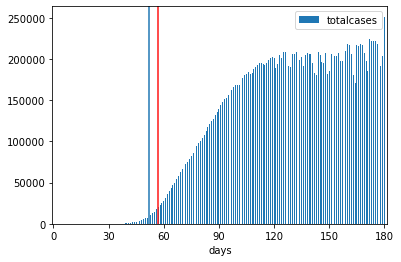

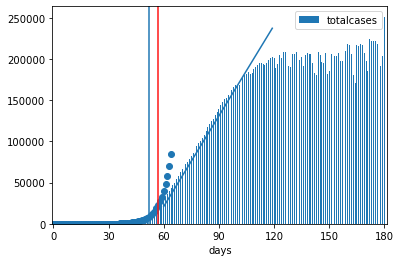

In [810]:
""" This function will computer cumulative cases , fit machine learning models on two stages of the epidemic 
    and produce several plots.

    - d is the number of days to use to make predictions using the machine learning model model_1. 
    it does NOT affect the sample used for training. 
    
    !! Please do not set d less than 65 if you want to plot the residual plot.
    
    
    Updates of the function: 
    
    
    - exp is to include a plot of the exponential growth fit on 61 days instead of 57
    The reason is that looking at daily cases (see later cells), it seems that the exponential growth stopped later than 57
    57 = lockdown date + incubation period.
    !! Please set exp to True or False !! To have the additional plot
    
    - Please residual to True to have a residual plot, otherwise False
    
    -please set london equal True to mark the day where masks were made mandatory on TFL
    
"""



def get_total(df,d,exp, residual, london):   
    days=[]
    total_cases=[]
    for n in range(182):
        tot= df[df["days"] ==pd.Timedelta(n, unit='d') ].totalcases.sum()
        days.append(n)
        total_cases.append(tot)
    
    new_df= pd.DataFrame({"days": days,"totalcases": total_cases})
    new_df.plot(kind='bar',x='days',y='totalcases', xticks=range(0,182,30), rot=0)
    
    plt.axvline(x=52)
    
    
    """A 5 days period has been included to show possible delay in how the measures affected transmission, 
    namely up to 5 days after the lockdown started, 
    the registered cases were still of infections occurred before the lockdown itself"""
    
    plt.axvline(x=57, color='#ff1414') # a buffer period of 10 days has been considered
    
    
    
    '''MACHINE LEARNING PART WITH SCI-KIT LEARN '''
    '''MACHINE LEARNING PART WITH SCI-KIT LEARN '''
    
    
    Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
    Y_1= Y_1.totalcases
    Y_1= Y_1 + 0.01 # get rid of zeroes
    Y_1= np.log(Y_1)# to make it "fittable" with linear regression 
    
    Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
    Y_2= Y_2.totalcases
    
    Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57 
    Y_3= Y_3.totalcases
    Y_3= Y_3 + 0.01 # get rid of zeroes
    Y_3= np.log(Y_3)
   
    
    'X used to train:'
    
    
    X_1=np.array(range(41,57))
    X_2=np.array(range(32))
    X_3=np.array(range(41,62))
    
    X_1=X_1.reshape(-1, 1)
    X_2=X_2.reshape(-1, 1)
    X_3=X_3.reshape(-1, 1) #This was added later, it is to fit the exponential model on the first 61 days, instead of 57 
    
    linear_1=LinearRegression()
    linear_2=LinearRegression()
    linear_3=LinearRegression()
    
    model_1=linear_1.fit(X_1,Y_1) 
    model_2=linear_2.fit(X_2,Y_2) 
    model_3=linear_3.fit(X_3,Y_3) #This was added later, it is to fit the exponential model on the first 61 days, instead of 57
    
    'X used to predict:'
    
    X_pred_2= np.array(range(60))
    X_pred_2= X_pred_2.reshape(-1, 1)
    
    X_pred_1= np.array(range(d))
    X_pred_1= X_pred_1.reshape(-1, 1)
    
    
    pred_1=model_1.predict(X_pred_1) #I expect this to be exponential 
    pred_2=model_2.predict(X_pred_2) #I expect this to be linear
    
    pred_3=model_3.predict(X_pred_1) #This was added later, it is to fit the exponential model on the first 61 days, instead of 57
    
    
    ''' END OF THE MACHINE LEARNING PART '''
    ''' END OF THE MACHINE LEARNING PART '''
    
    pred_1= np.exp(pred_1)
    
    pred_3= np.exp(pred_3)
    
    "Same code as before. just to duplicate plot"
    
    new_df.plot(kind='bar',x='days',y='totalcases', xticks=range(0,182,30), rot=0)
    plt.axvline(x=52)
    plt.axvline(x=57, color='#ff1414')
    #plt.figure(figsize=(10,8))
   
    "END"
    
    
    plt.scatter(np.array(range(d)),pred_1)
    
    plt.plot(np.array(range(60,120)),pred_2)
    while london: 
        plt.axvline(x=139, color='#2E8B57')
        break
    
    while exp:
        plt.scatter(np.array(range(d)),pred_3, color='#ff8a14')
        break 
        
    while residual:
        
        residual= pred_3- new_df.totalcases[:d]
        
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18.5, 7.5, forward=True)
        fig.suptitle('cumulative number of cases predicted and residual plot')
        ax1.bar(np.array(range(d)),residual, color='#ff8a14')
        
        ax2.scatter(new_df[:57].totalcases,pred_3[:57], label="predicted cases pre-lockdown")
        ax2.scatter(new_df[57:65].totalcases,pred_3[57:65],color="#ff1414", label="predicted cases after the lockdown")
        ax2.plot(new_df[:d],new_df[:d],'--', color='#ff8a14')
        ax2.legend()
        plt.show()
        break 
        
    
        
    return new_df
    
total_England_df = get_total(England_df, 65, False, False, False)


<ipython-input-810-f6e714ed381b>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-810-f6e714ed381b>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-810-f6e714ed381b>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57


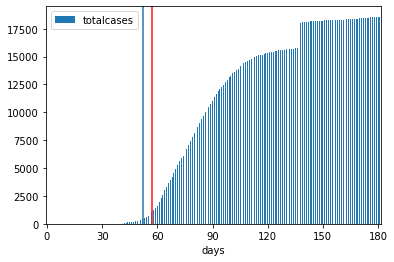

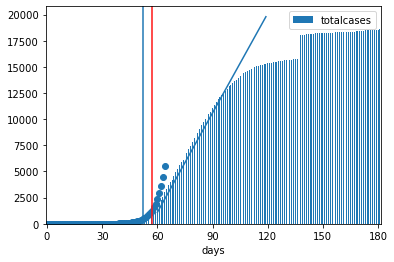

In [811]:
total_Scotland_df= get_total(Scotland_df,65,False,False, False)



<ipython-input-810-f6e714ed381b>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-810-f6e714ed381b>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-810-f6e714ed381b>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57


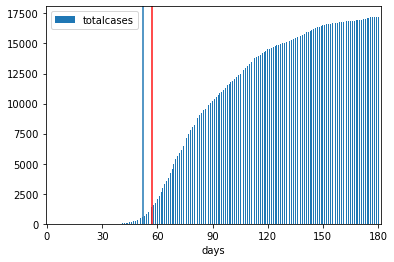

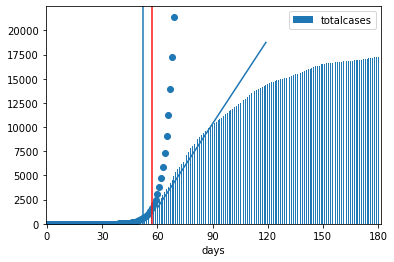

In [812]:
total_Wales_df= get_total(Wales_df, 70, False,False, False)



<ipython-input-810-f6e714ed381b>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-810-f6e714ed381b>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-810-f6e714ed381b>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57


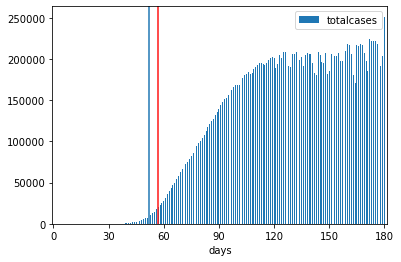

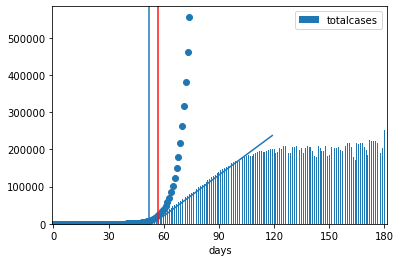

In [813]:
total_England_df= get_total(England_df, 75, False,False, False)  #let´s check the exponential progression at day 75

The pre-lockdown trajectiory seems to be dangerously steep.

In order to better analyse the spread of covid-19, I will compute **daily** cases increase in England, further analysis will be performed on areas of London only, to see the effect of masks becoming mandatory on TFL, the public transport network in London. 

In [814]:
def get_daily(df):
    
    b= df[1:]


    a=df.drop(index=181, axis=0)


    b.index= a.index

    daily_df= b-a

    daily_df[daily_df["totalcases"] < 0] = 0
    daily_df.plot(kind='bar',x='days',y='totalcases', xticks=range(0,180,30), rot=0)
    plt.axvline(x=52)
    plt.axvline(x=57, color='#ff1414')
    
    return daily_df

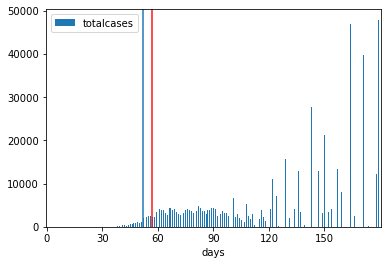

In [815]:
daily_England_df= get_daily(total_England_df)

This is roughly a plot similar to the official published records on the progression of covid-19 in the UK. Let's have a closer look at the first half of the data.

Unfortunately this is a bad way to calculate daily infections because the totalcases are not always increasing -  not sure why. Some cases removed.

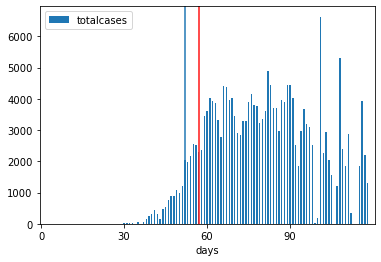

In [816]:
daily_120= daily_England_df.drop(index=list(range(120,180)))

daily_120.plot(kind='bar',x='days',y='totalcases', xticks=range(0,120,30), rot=0)
plt.axvline(x=52)
plt.axvline(x=57, color='#ff1414')



It seems like exponential growth stopped slightly later than 5 days after the lockdown. Daily cases were quickly increasing until they stabilised around an average between 3 and 5 thousands per day. 

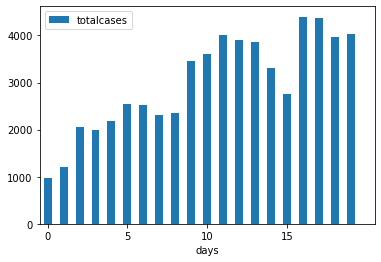

In [817]:
daily_50_70= daily_df.drop(index=list(range(70,180)))

daily_50_70= daily_50_70.drop(index=list(range(50)))

daily_50_70.plot(kind='bar',x='days',y='totalcases', xticks=range(0,20,5), rot=0)
plt.axvline(x=52)
plt.axvline(x=57, color='#ff1414')


day 61 (11 on the plot above), seems to be a good candidate to when roughly exponential growth stopped. let´s re-fit the model.

<ipython-input-810-f6e714ed381b>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-810-f6e714ed381b>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-810-f6e714ed381b>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57


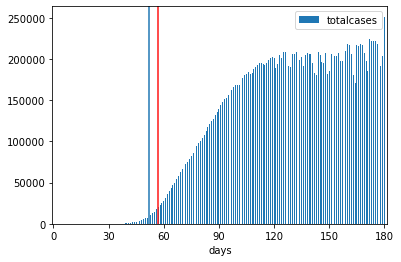

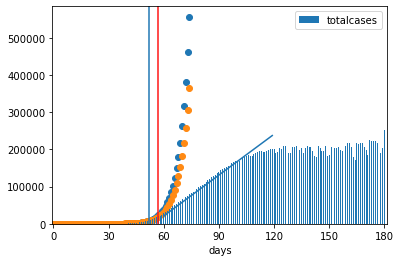

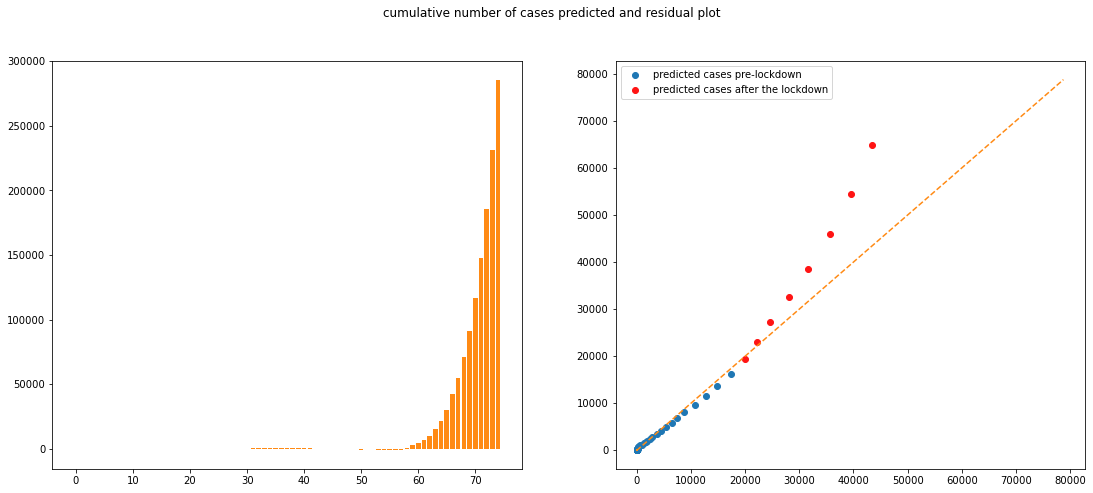

,days,totalcases
0,0,1.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,1.0
...,...,...
177,177,202671.0
178,178,191016.0
179,179,203307.0
180,180,251247.0


In [818]:
""" True as the fourth argument will display a second exponential model fit until day 61 (which is after the lockdown)"""

get_total(England_df, 75, True, True, False) 

Let´s have a look at London! 
On June 15 face covering became mandatory on the TFL public transport network. 

In [819]:
London_df= df.loc[df["area"].isin(['Hackney and City of London',
              'Westminster',
"Kensington and Chelsea",
"Hammersmith and Fulham",
"Wandsworth",
"Lambeth",
"Southwark",
"Tower Hamlets",
"Islington",
"Camden",
"Brent",
"Ealing",
"Hounslow",
"Richmond upon Thames",
"Kingston upon Thames",
"Merton",
"Sutton",
"Croydon",
"Bromley",
"Lewisham",
"Greenwich",
"Bexley",
"Havering",
"Barking and Dagenham",
"Redbridge",
"Newham",
"Waltham Forest",
"Haringey",
"Enfield",
"Barnet",
"Harrow",
"Hillingdon"])]




<ipython-input-810-f6e714ed381b>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-810-f6e714ed381b>:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-810-f6e714ed381b>:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57


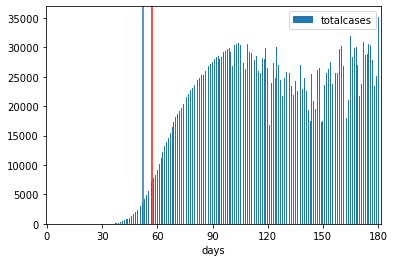

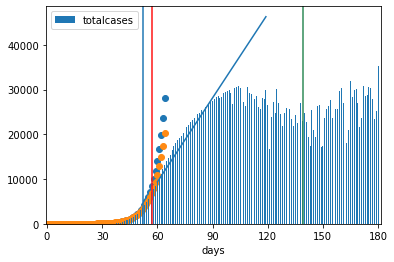

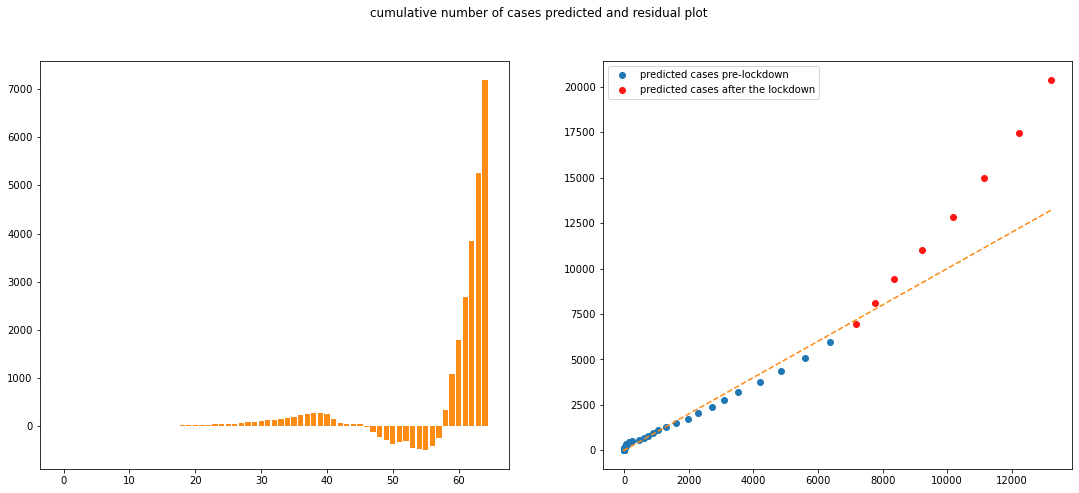

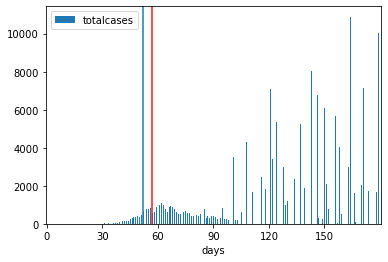

In [820]:
London_total_df=get_total(London_df, 65, True, True, True) 
London_daily_df= get_daily(London_total_df)



The second, linear model is not very adequate to explain the post-lockdown phase in London looking at how cases were increasing, that is interesting and requires further investigation.

### conclusion:

This project was more about getting practice with data and ML, but it is clear that an exponential growth can explain the **early** progression of covid-19 in England, the number of cases were doubling *roughly* every 5 days (simply counting the number of dots in the residual plot between 10k and 20k for example). 

It is also clear that the lockdown stopped exponential growth, a linear growth instead lasted for slightly longer than a month, then the rate of new cases started to slow down even more. The linear growth can probably be explained by the spread of the virus within households, in which one person was infected before the lockdown started or even within households through interactions between close friends, family members etc.

Considering a chain of infection within a family and the incubation period, it is reasonable to expect to see in-household contagion happening over a the period of time mentioned above. 

The bottomline is that the exponental growth could have caused several thousand of deaths within a relatively short period of time:

<ipython-input-744-954cd232fd64>:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-744-954cd232fd64>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-744-954cd232fd64>:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_3= new_df[new_df["days"] < 62 ][new_df["days"] > 40]   #This was added later, it is to fit the exponential model on the first 61 days, instead of 57
<ipython-input-744-954cd232fd64>:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_1= new_df[new_df["days"] < 57 ][new_df["days"] > 40]
<ipython-input-744-954cd232fd64>:55: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Y_2= new_df[new_df["days"] < 90 ][new_df["days"] > 57 ]
<ipython-input-744-954cd232fd64>:58: UserWarning: Bo

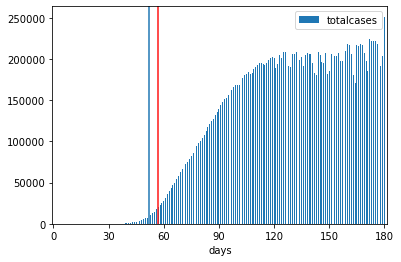

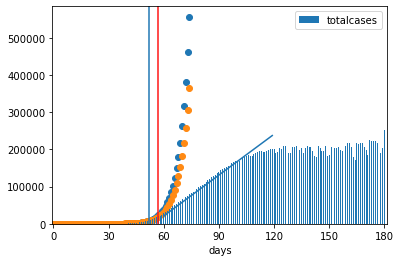

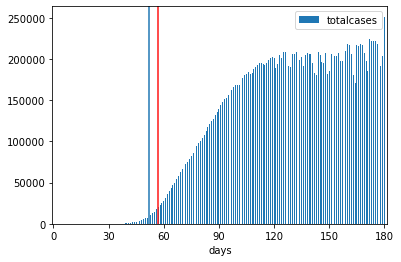

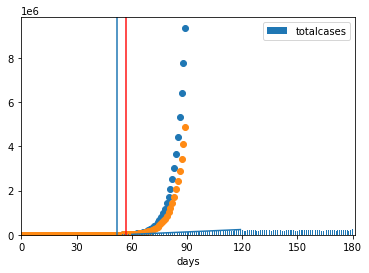

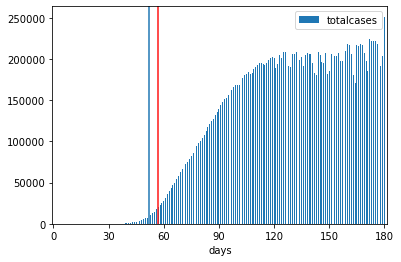

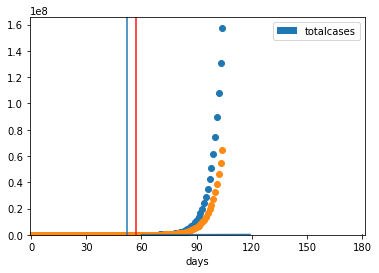

In [758]:
total_England_df= get_total(England_df, 75, True,False, False)
total_England_df= get_total(England_df, 90, True,False, False)
total_England_df= get_total(England_df, 105, True,False, False)

*I am considering the orange exp growth more reliable for the following:*

Roughly 500k cases would have been recorded in slighly more than two weeks from day 60, 5 mln within roughly a month if no lockdown was enforced and 60 millions within 45 days, this last figure is not accurate because it is almost the entire population of the UK and I imagine exponential growth to slow down when most people have been infected.

By assuming a mortality rate of 0.5-1%, between 300'000 and 600'000 people would have died as a consequence of infections that would have happened within 45 days from day 60, namely on day 105 which was the 14th of May 2020. Most of these deaths would have occurred, considering the incubation period, between the end of May and the end of June 2020.

This is without considering the effect mentioned above which would have made numbers smaller, but also without considering overwhelmed hospitals, which would have meant many more deaths, even for other medical conditions not related to covid. 